In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.x13 import x13_arima_analysis

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib agg
fig, ax = plt.subplots(figsize=(12,6))

In [2]:
balance     = pd.read_parquet('../data/argentina_primario_legal.parquet')
ipc         = pd.read_parquet('../data/argetina_ipc_meu.parquet', columns=['ipc_tucuman'])
gdp_nominal = pd.read_parquet('../data/argentina_gdp_meu.parquet')

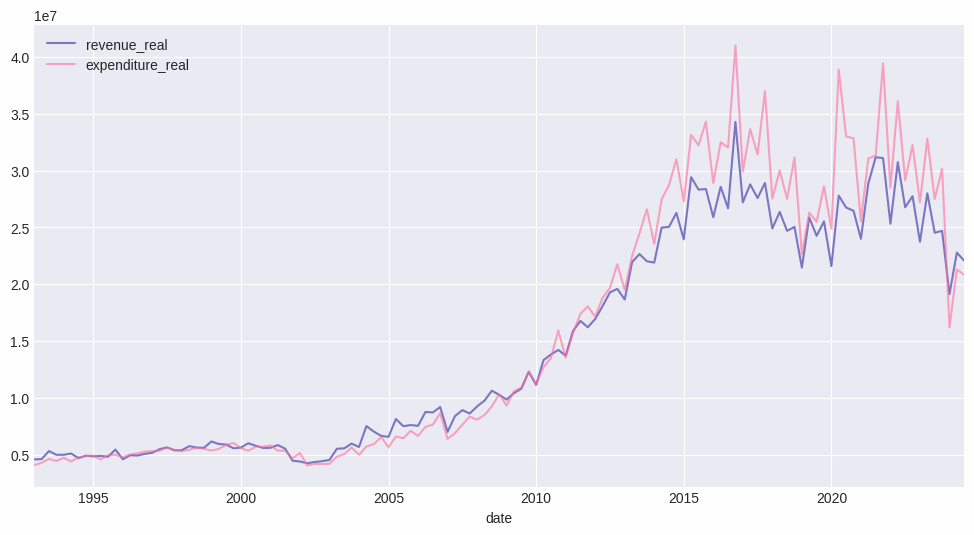

In [3]:
ax.clear()

mg = balance.join(ipc)

mg = mg.resample('QS').sum()

mg = mg.join(gdp_nominal)

deflator = (mg.ipc_tucuman / mg.loc[pd.to_datetime('2024-01-01'), 'ipc_tucuman'])

mg['revenue_real']    = mg.revenue     / deflator
mg['expenditure_real'] = mg.expenditure / deflator
mg['gdp_real_novo']    = mg.gdp_nominal_novo / deflator
mg['gdp_real_velho']   = mg.gdp_nominal_velho / deflator

gdp_correction_factor = (mg.gdp_real_novo / mg.gdp_real_velho).loc[pd.to_datetime('2004-01-01')]

mg.gdp_real_velho = mg.gdp_real_velho * gdp_correction_factor

mg.gdp_real_velho = mg.gdp_real_velho.replace(0, np.nan)
mg.gdp_real_novo = mg.gdp_real_novo.replace(0, np.nan)

mg['gdp_real'] = mg.gdp_real_novo.combine_first(mg.gdp_real_velho)

mg[['revenue_real', 'expenditure_real']].plot(ax=ax)

fig

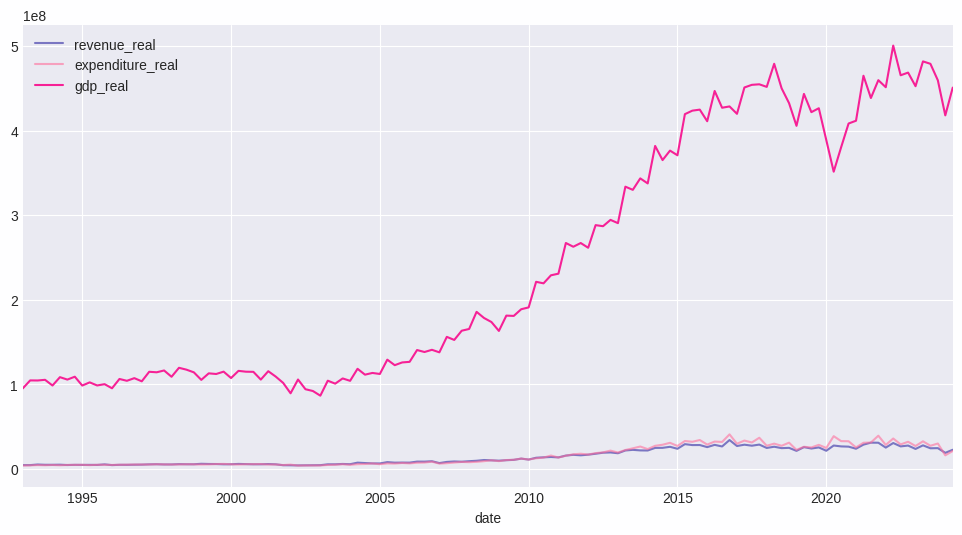

In [4]:
ax.clear()

cool_guy = mg[['revenue_real', 'expenditure_real', 'gdp_real']].copy().dropna()

cool_guy.plot(ax=ax)

fig

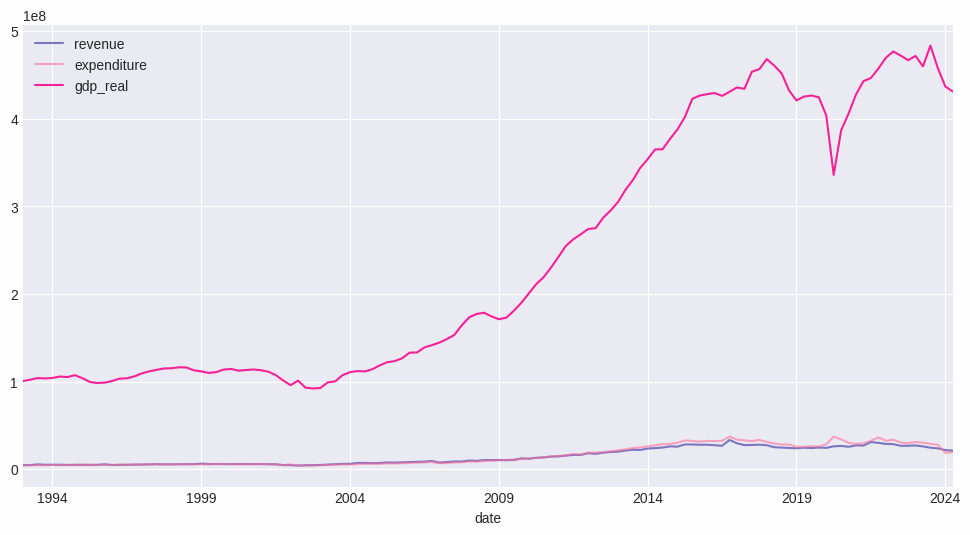

In [44]:
ax.clear()

revenue_deseas     = x13_arima_analysis(cool_guy.revenue_real).seasadj
expenditure_deseas = x13_arima_analysis(cool_guy.expenditure_real).seasadj
gdp_real_deseas    = x13_arima_analysis(cool_guy.gdp_real).seasadj


even_cooler_guy = pd.DataFrame(
	{
		'revenue': revenue_deseas,
		'expenditure': expenditure_deseas,
		'gdp_real': gdp_real_deseas,
    }
)

even_cooler_guy.plot(ax=ax)

fig

In [43]:
even_cooler_guy.to_parquet('../data/even_cooler_guy.parquet')